<div hidden>
$\DeclareMathOperator{\tr}{tr}$
$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
</div>

# Trace regression

Existem problemas de regressão cujo parâmetro tem estrutura de matriz. Estimar e fazer inferência preservando a estrutura de matriz é em certos casos essencial, especialmente quando o parâmetro tem posto pequeno apesar de ser denso. Neste projeto iremos implementar métodos iterativos para achar a solução do seguinte estimador de mínimos quadrados regularizado:

$$
\min_{B\in\mathbb{R}^{d_1\times d_2}}f(B)=\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B) ))^2 + 
\lambda\Vert B\Vert_N, 
$$
onde $(y_1,X_1), \ldots, (y_n,X_n)$ é uma amostra de labels/features em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$. Àcima, $\lambda>0$ é um hyper-parâmetro positivo e 

$$
\Vert B\Vert_N := \sum_{j=1}^{\min\{d_1,d_2\}}\sigma(B),
$$

é a *norma nuclear* da matriz $B$, onde $\sigma_1(B)\ge\cdots\ge\sigma_{\min\{d_1,d_2\}}(B)$ são os valores singulares de $B$.  

# Soft-Thresholding matricial

Recorde que o passo de iteração do método gradiente proximal é calcular o *operador proximal* da norma $\lambda\Vert\cdot\Vert_N$:
$$
P(W,\lambda)\in\argmin_{B\in\mathbb{R}^{d_1\times d_2}}\left\{
\frac{1}{2}\Vert W - B\Vert_F^2 + \lambda\Vert B\Vert_N
\right\}.
$$


$P(W,\lambda)$ tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina
$$
S(\gamma,\lambda):=\sign(\gamma)\cdot\max\{|\gamma|-\lambda,0\}.
$$
Àcima, $\sign(\gamma)$ é o sinal de $\gamma$. Seja agora a decomposição de valores singulares (SVD) de $W$:
$$
W = U\cdot D(\gamma_1,\ldots,\gamma_r)\cdot V^\top.
$$
Então, 
$$
P(W,\lambda) = U\cdot D\left( S(\gamma_1,\lambda),\ldots, S(\gamma_r,\lambda)\right)\cdot V^\top, 
$$
chamado de matriz *soft-thresholding* de $W$ com threshold $\lambda$.

In [1]:
import matplotlib
import numpy as np
import scipy
from scipy.stats import ortho_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la

# Exercício 1: Gerando dados

Construa uma função ``data_genP(d1,d2,r,B_mag)`` que toma $d_1$, $d_2$, posto $r$ e número positivo ``B_mag`` e retorna a matriz $d_1\times d_2$ de posto $r$ e valores singulares todos iguais a ``B_mag``. Ao gerar esta matriz $B^*$, use a função ```scipy.stats.ortho_group``` para construir duas matrizes $U$ e $V$ aleatórias ortogonais de dimensões $d_1\times r$ e $d_2\times r$ respectivamente; retorne
$B^*=U\cdot D(B_{mag},\ldots,B_{mag})\cdot V^\top$. 

In [2]:

def data_genP(d1, d2, r, B_mag):
    """
    Gera uma matriz de posto r e valores singulares iguais a B_mag.
    
    Parâmetros:
    - d1: número de linhas da matriz
    - d2: número de colunas da matriz
    - r: posto da matriz
    - B_mag: valor singular para todos os r valores
    
    Retorna:
    - B*: matriz de dimensões (d1, d2) com posto r e valores singulares iguais a B_mag
    """
    # Gerando matrizes ortogonais U (d1 x r) e V (d2 x r)
    U = ortho_group.rvs(dim=d1)[:, :r]
    V = ortho_group.rvs(dim=d2)[:, :r]
    
    # Criando a matriz diagonal com todos os valores singulares iguais a B_mag
    Sigma = np.diag([B_mag] * r)
    
    # Calculando B* = U * Sigma * V^T
    B_star = U @ Sigma @ V.T
    
    return B_star

In [3]:
#Exemplo:
d_1=30
d_2=50
r=5
B_mag=10
B_true = data_genP(d_1,d_2,r,B_mag)
B_true.shape

(30, 50)

# Exercício:

Construa uma função ``data_genXe(n,d_1,d_2,B_true,sd)`` que toma $n$, $d_1$, $d_2$, $B_{\text{true}}$ e um número positivo ``sd`` e constrói os dados ``X``, uma lista de $n$ matrizes $X_i$ de dimensão $d_1\times d_2$ independentes cujas entradas são iid normais padrão. A função também retorna o vetor ``y`` de dimensão $n$ cujas coordenadas satisfazem

$$
y_i = \tr(X_i^\top B_{\text{true}}) + \text{sd}\cdot\epsilon_i,
$$
onde $\{\epsilon_i\}_{i=1}^n$ é uma sequência iid de normais padrão. 

In [4]:
def data_genXe(n, d1, d2, B_true, sd):
    """
    Gera dados X e y para o problema de regressão de traço.
    
    Parâmetros:
    - n: número de amostras
    - d1: número de linhas das matrizes X_i
    - d2: número de colunas das matrizes X_i
    - B_true: matriz verdadeira B* gerada previamente
    - sd: desvio padrão para o ruído normal
    
    Retorna:
    - X: lista de n matrizes X_i de dimensão (d1 x d2)
    - y: vetor de dimensão n cujas coordenadas satisfazem a fórmula dada
    """
    # Gerando lista de matrizes X_i iid normais padrão
    X = [np.random.randn(d1, d2) for _ in range(n)]
    
    # Gerando vetor y de acordo com a fórmula y_i = tr(X_i^T B_true) + sd * epsilon_i
    epsilon = np.random.randn(n)  # Ruído iid normal padrão
    y = np.array([np.trace(X_i.T @ B_true) + sd * epsilon_i for X_i, epsilon_i in zip(X, epsilon)])
    
    return X, y


In [5]:
#Exemplo:
sd = 2
n = 100

B_true = data_genP(d_1,d_2,r,B_mag)
X,y = data_genXe(n,d_1,d_2,B_true,sd)

In [6]:
type(X), len(X), X[0].shape

(list, 100, (30, 50))

In [7]:
type(y), len(y), y.shape

(numpy.ndarray, 100, (100,))

# Exercício:

Construa uma função ``soft(x,l)`` que retorna $S(x,\lambda)$.

In [8]:
def soft(x, l):
    """
    Aplica o operador de soft-thresholding à entrada x com parâmetro l (lambda).
    
    Parâmetros:
    - x: valor de entrada (escalar ou array)
    - l: valor do threshold (lambda)
    
    Retorna:
    - O resultado do operador de soft-thresholding S(x, l).
    """
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

# Exercício 2: 

Vamos usar o método gradiente proximal para resolver o problema àcima:

\begin{align*}
W_{k+1} &:= B_k - \frac{1}{L}\nabla f(B_k),\\
B_{k+1} &:= P\left(W_{k+1},\frac{\lambda}{L}\right).
\end{align*}

Construa uma função ``trace_reg(n,d_1,d_2,X,y,L,lambd,B0,t_final)`` onde, $1/L$ é o passo, ``lambd`` ($=\lambda$) é o fator de penalização, ``B0`` é o ponto inicial, a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B_k))^2$ e o último iterado $B_{\text{t_final}}$. Use penalização

$$
\lambda = \text{sd}\sqrt{\frac{d_1+d_2}{n}}, 
$$

e passo $A/L$ ajustando $A\ge1$ com

$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right),
$$ 
onde $\text{vec}(X_i)$ representa a matrix $d_1\times d_2$ $X_i$ em forma vetorial de dimensão $d_1d_2$. 

**TEM QUE ENTENDER COMO CALCULAR O GRADIENTE}!**

In [9]:
def trace_reg(n, d1, d2, X, y, L, lambd, B0, t_final):
    """
    Aplica o método de gradiente proximal para o problema de trace regression.
    
    Parâmetros:
    - n: número de amostras
    - d1: número de linhas das matrizes X_i
    - d2: número de colunas das matrizes X_i
    - X: lista de n matrizes X_i de dimensão (d1 x d2)
    - y: vetor de dimensão n
    - L: fator de suavidade (Lipschitz constant)
    - lambd: fator de penalização (lambda)
    - B0: ponto inicial da iteração
    - t_final: número de iterações
    
    Retorna:
    - seq_loss: sequência de valores da função de perda ao longo das iterações
    - B_final: última matriz B após t_final iterações
    """
    
    def grad_f(B):
        """Calcula o gradiente de f em relação a B."""
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n
    
    def soft_threshold(W, lambd_L):
        """Aplica o operador de soft-thresholding à matriz W."""
        U, S, Vt = la.svd(W, full_matrices=False)
        S_thresholded = np.maximum(S - lambd_L, 0)
        return U @ np.diag(S_thresholded) @ Vt
    
    B_k = B0
    seq_loss = []
    
    for t in range(t_final):
        # Calcula o gradiente da função de perda
        grad_B = grad_f(B_k)
        
        # Passo de atualização de W_k+1
        W_k1 = B_k - (1 / L) * grad_B
        
        # Atualização de B_k+1 usando soft-thresholding
        B_k1 = soft_threshold(W_k1, lambd / L)
        
        # Armazena a perda na sequência
        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k1)) ** 2 for i in range(n)])
        seq_loss.append(loss)
        
        # Atualiza o iterado B_k
        B_k = B_k1
    
    return seq_loss, B_k

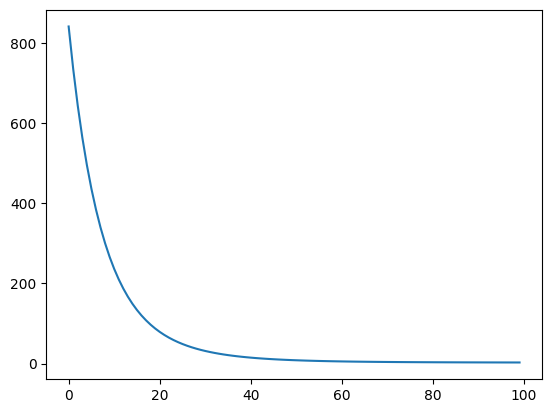

In [10]:
#Exemplo:
B0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))


lambd = sd*np.sqrt((d_1+d_2)/n)      

f1 = trace_reg(n,d_1,d_2,X,y,L,lambd,B0,t_final)
plt.plot(f1[0])

# Exercício: 

O que acontece se $A$ for muito pequeno? 

Se o fator \( A \) for muito pequeno, o passo \( 1/L \) no método de gradiente proximal se tornará muito grande, o que pode causar problemas de divergência. O algoritmo pode se afastar da solução ótima em vez de se aproximar, fazendo com que as iterações "pulem" além do ponto ideal. Em vez de convergir, o processo pode se desestabilizar e perder a trajetória correta.

Além disso, com um passo excessivamente grande, as atualizações de \( B_k \) podem resultar em oscilações. Em vez de ajustar gradualmente a solução em direção ao mínimo, o algoritmo pode alternar de um lado para outro em torno da solução, sem nunca estabilizar. Esse comportamento impede que o método alcance uma convergência suave e eficiente.

Finalmente, a instabilidade do processo aumenta, pois o gradiente \( \nabla f(B) \) é amplificado indevidamente, levando a saltos descontrolados nos iterados. Essa instabilidade pode fazer com que o algoritmo se torne numericamente impreciso e, em casos extremos, ele pode não convergir de forma alguma. Por isso, é fundamental escolher um valor de \( A \) suficientemente grande para garantir uma taxa de convergência controlada e estável.


# Exercício 3: 

Agora, vamos usar o método gradiente proximal acelerado: iniciando de `B0=Z0` e $t_0=1$:

\begin{align*}
Z_{k+1}&:= P\left(
B_k - (1/L)\nabla f(B_k), \frac{\lambda}{L}
\right),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
B_{k+1} &:= Z_{k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{k+1} - Z_{k}).
\end{align*}

Construa uma função ``trace_reg_acc(n,d_1,d_2,X,y,L,lambd,B0,t_final)`` onde, $1/L$ é o passo, ``lambd`` ($=\lambda$) é o fator de penalização, ``B0`` é o ponto inicial, a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B_k))^2$ e o último iterado $B_{\text{t_final}}$. Use penalização

$$
\lambda = \text{sd}\sqrt{\frac{d_1+d_2}{n}}, 
$$

e passo $A/L$ ajustando $A\ge1$ com

$$
L = ??,
$$ 

In [11]:
def trace_reg_acc(n, d1, d2, X, y, L, lambd, B0, t_final):
    """
    Aplica o método de gradiente proximal acelerado para o problema de trace regression.
    
    Parâmetros:
    - n: número de amostras
    - d1: número de linhas das matrizes X_i
    - d2: número de colunas das matrizes X_i
    - X: lista de n matrizes X_i de dimensão (d1 x d2)
    - y: vetor de dimensão n
    - L: fator de suavidade (Lipschitz constant)
    - lambd: fator de penalização (lambda)
    - B0: ponto inicial da iteração
    - t_final: número de iterações
    
    Retorna:
    - seq_loss: sequência de valores da função de perda ao longo das iterações
    - B_final: última matriz B após t_final iterações
    """
    
    def grad_f(B):
        """Calcula o gradiente de f em relação a B."""
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n
    
    def soft_threshold(W, lambd_L):
        """Aplica o operador de soft-thresholding à matriz W."""
        U, S, Vt = la.svd(W, full_matrices=False)
        S_thresholded = np.maximum(S - lambd_L, 0)
        return U @ np.diag(S_thresholded) @ Vt
    
    B_k = B0
    Z_k = B0.copy()
    t_k = 1
    seq_loss = []
    
    for _ in range(t_final):
        # Calcula o gradiente da função de perda
        grad_B = grad_f(B_k)
        
        # Passo de atualização Z_k+1
        Z_k1 = soft_threshold(B_k - (1 / L) * grad_B, lambd / L)
        
        # Atualiza t_k+1
        t_k1 = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        
        # Atualiza B_k+1
        B_k1 = Z_k1 + (t_k - 1) / t_k1 * (Z_k1 - Z_k)
        
        # Armazena a perda na sequência
        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k1)) ** 2 for i in range(n)])
        seq_loss.append(loss)
        
        # Atualiza os valores para a próxima iteração
        B_k = B_k1
        Z_k = Z_k1
        t_k = t_k1
    
    return seq_loss, B_k

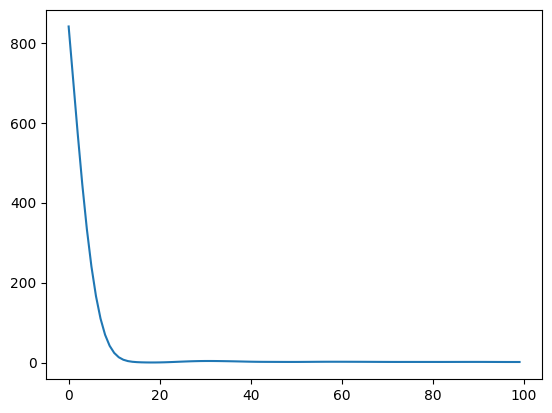

In [12]:
#Exemplo: 
B0 = np.ones((d_1,d_2))
t_final = 100
lambd = sd*np.sqrt((d_1+d_2)/n)      

f2 = trace_reg_acc(n,d_1,d_2,X,y,L,lambd,B0,t_final)
plt.plot(f2[0])

# Exercício 4: 

Implemente num mesmo gráfico os erros $k\mapsto\frac{1}{2n}\sum_{i=1}^n(y_i-\tr(X_i^\top B_k))^2$ de cada método em função no número de iterações.

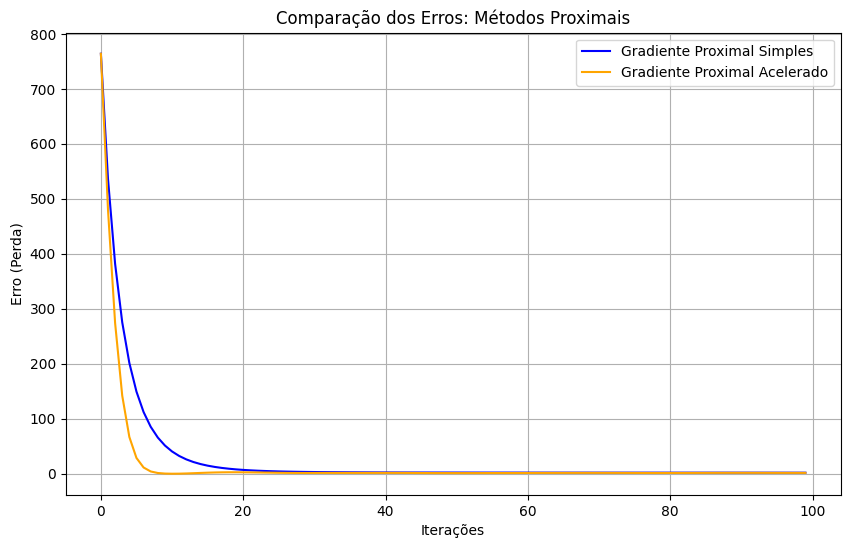

In [14]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

# Funções para gerar dados
def data_genP(d1, d2, r, B_mag):
    U = ortho_group.rvs(d1, random_state=None)[:, :r]  # Matriz ortogonal d1 x r
    V = ortho_group.rvs(d2, random_state=None)[:, :r]  # Matriz ortogonal d2 x r
    D = np.diag([B_mag] * r)  # Matriz diagonal com valores singulares iguais a B_mag
    return U @ D @ V.T  # Retorna a matriz B*

def data_genXe(n, d1, d2, B_true, sd):
    X = [np.random.randn(d1, d2) for _ in range(n)]  # Matriz X_i com entradas iid normais padrão
    epsilon = np.random.randn(n)  # Erros iid normais padrão
    y = np.array([np.trace(X[i].T @ B_true) + sd * epsilon[i] for i in range(n)])  # y_i
    return X, y

# Função soft-thresholding
def soft_threshold(W, lambd_L):
    U, S, Vt = la.svd(W, full_matrices=False)
    S_thresholded = np.maximum(S - lambd_L, 0)
    return U @ np.diag(S_thresholded) @ Vt

# Método de gradiente proximal simples
def trace_reg(n, d1, d2, X, y, L, lambd, B0, t_final):
    def grad_f(B):
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n

    B_k = B0
    seq_loss = []

    for _ in range(t_final):
        grad_B = grad_f(B_k)
        W_k1 = B_k - (1 / L) * grad_B
        B_k = soft_threshold(W_k1, lambd / L)
        
        # Armazena a perda
        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k)) ** 2 for i in range(n)])
        seq_loss.append(loss)

    return seq_loss, B_k

# Método de gradiente proximal acelerado
def trace_reg_acc(n, d1, d2, X, y, L, lambd, B0, t_final):
    def grad_f(B):
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n

    B_k = B0
    Z_k = B0.copy()
    t_k = 1
    seq_loss = []

    for _ in range(t_final):
        grad_B = grad_f(B_k)
        Z_k1 = soft_threshold(B_k - (1 / L) * grad_B, lambd / L)
        t_k1 = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        B_k1 = Z_k1 + (t_k - 1) / t_k1 * (Z_k1 - Z_k)

        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k1)) ** 2 for i in range(n)])
        seq_loss.append(loss)

        B_k = B_k1
        Z_k = Z_k1
        t_k = t_k1

    return seq_loss, B_k

# Parâmetros para geração de dados
d_1 = 30
d_2 = 50
n = 100
r = 5
B_mag = 10
sd = 2

# Gerando B_true
B_true = data_genP(d_1, d_2, r, B_mag)

# Gerando dados X e y
X, y = data_genXe(n, d_1, d_2, B_true, sd)

# Parâmetros iniciais
B0 = np.ones((d_1, d_2))
t_final = 100

# Cálculo de L
aux = []
for i in range(n):
    xi = np.asarray(X[i]).reshape(-1, 1)  # Vetorizando X_i
    aux.append(xi @ xi.T)
L = 4 * np.max(la.eigvalsh(sum(aux) / n))

# Definindo lambda
lambd = sd * np.sqrt((d_1 + d_2) / n)

# Aplicando o método de gradiente proximal simples
seq_loss_simple, _ = trace_reg(n, d_1, d_2, X, y, L, lambd, B0, t_final)

# Aplicando o método de gradiente proximal acelerado
seq_loss_accelerated, _ = trace_reg_acc(n, d_1, d_2, X, y, L, lambd, B0, t_final)

# Plotando os erros dos dois métodos
plt.figure(figsize=(10, 6))
plt.plot(seq_loss_simple, label='Gradiente Proximal Simples', color='blue')
plt.plot(seq_loss_accelerated, label='Gradiente Proximal Acelerado', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Erro (Perda)')
plt.title('Comparação dos Erros: Métodos Proximais')
plt.legend()
plt.grid()
plt.show()


# Exercício:

Refaça os exercícios com $\sigma=1$ e $\sigma=10$. Qual a diferença quando $\sigma=10$? Tem alguma intuição de porque isso acontece?

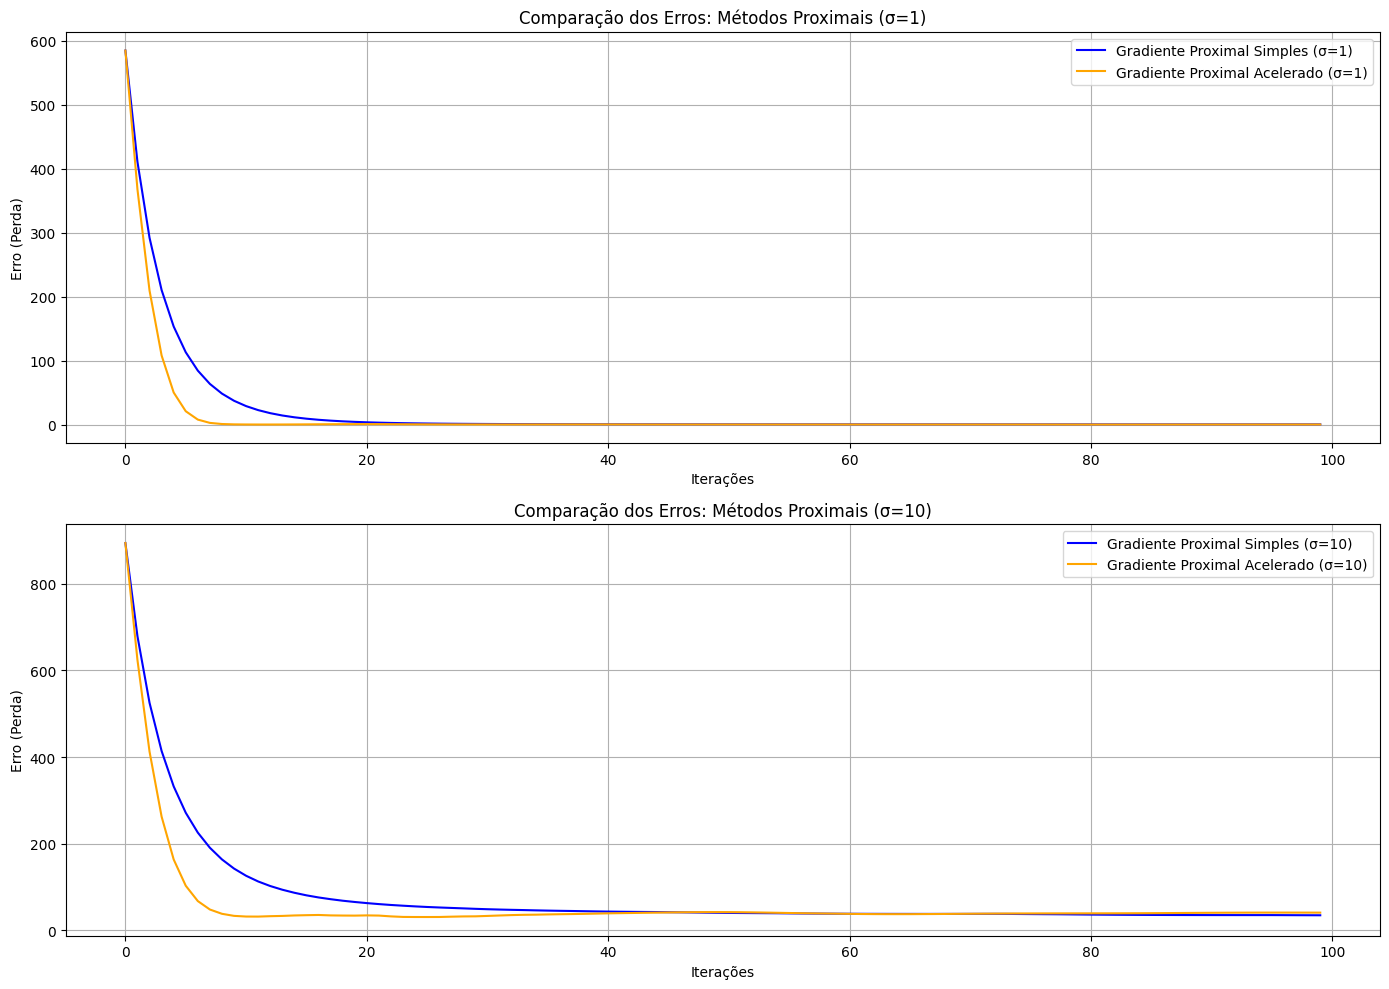

In [15]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

# Funções para gerar dados
def data_genP(d1, d2, r, B_mag):
    U = ortho_group.rvs(d1, random_state=None)[:, :r]  # Matriz ortogonal d1 x r
    V = ortho_group.rvs(d2, random_state=None)[:, :r]  # Matriz ortogonal d2 x r
    D = np.diag([B_mag] * r)  # Matriz diagonal com valores singulares iguais a B_mag
    return U @ D @ V.T  # Retorna a matriz B*

def data_genXe(n, d1, d2, B_true, sd):
    X = [np.random.randn(d1, d2) for _ in range(n)]  # Matriz X_i com entradas iid normais padrão
    epsilon = np.random.randn(n) * sd  # Erros iid normais com desvio padrão sd
    y = np.array([np.trace(X[i].T @ B_true) + epsilon[i] for i in range(n)])  # y_i
    return X, y

# Função soft-thresholding
def soft_threshold(W, lambd_L):
    U, S, Vt = la.svd(W, full_matrices=False)
    S_thresholded = np.maximum(S - lambd_L, 0)
    return U @ np.diag(S_thresholded) @ Vt

# Método de gradiente proximal simples
def trace_reg(n, d1, d2, X, y, L, lambd, B0, t_final):
    def grad_f(B):
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n

    B_k = B0
    seq_loss = []

    for _ in range(t_final):
        grad_B = grad_f(B_k)
        W_k1 = B_k - (1 / L) * grad_B
        B_k = soft_threshold(W_k1, lambd / L)
        
        # Armazena a perda
        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k)) ** 2 for i in range(n)])
        seq_loss.append(loss)

    return seq_loss, B_k

# Método de gradiente proximal acelerado
def trace_reg_acc(n, d1, d2, X, y, L, lambd, B0, t_final):
    def grad_f(B):
        grad = np.zeros_like(B)
        for i in range(n):
            Xi = X[i]
            error = np.trace(Xi.T @ B) - y[i]
            grad += error * Xi
        return grad / n

    B_k = B0
    Z_k = B0.copy()
    t_k = 1
    seq_loss = []

    for _ in range(t_final):
        grad_B = grad_f(B_k)
        Z_k1 = soft_threshold(B_k - (1 / L) * grad_B, lambd / L)
        t_k1 = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        B_k1 = Z_k1 + (t_k - 1) / t_k1 * (Z_k1 - Z_k)

        loss = (1 / (2 * n)) * np.sum([(y[i] - np.trace(X[i].T @ B_k1)) ** 2 for i in range(n)])
        seq_loss.append(loss)

        B_k = B_k1
        Z_k = Z_k1
        t_k = t_k1

    return seq_loss, B_k

# Parâmetros para geração de dados
d_1 = 30
d_2 = 50
n = 100
r = 5
B_mag = 10

# Executando com sigma = 1
sd_1 = 1
B_true_1 = data_genP(d_1, d_2, r, B_mag)
X_1, y_1 = data_genXe(n, d_1, d_2, B_true_1, sd_1)

# Parâmetros iniciais
B0 = np.ones((d_1, d_2))
t_final = 100

# Cálculo de L
aux = []
for i in range(n):
    xi = np.asarray(X_1[i]).reshape(-1, 1)  # Vetorizando X_i
    aux.append(xi @ xi.T)
L = 4 * np.max(la.eigvalsh(sum(aux) / n))

# Definindo lambda
lambd_1 = sd_1 * np.sqrt((d_1 + d_2) / n)

# Aplicando o método de gradiente proximal simples
seq_loss_simple_1, _ = trace_reg(n, d_1, d_2, X_1, y_1, L, lambd_1, B0, t_final)

# Aplicando o método de gradiente proximal acelerado
seq_loss_accelerated_1, _ = trace_reg_acc(n, d_1, d_2, X_1, y_1, L, lambd_1, B0, t_final)

# Executando com sigma = 10
sd_2 = 10
B_true_2 = data_genP(d_1, d_2, r, B_mag)
X_2, y_2 = data_genXe(n, d_1, d_2, B_true_2, sd_2)

# Cálculo de L
aux = []
for i in range(n):
    xi = np.asarray(X_2[i]).reshape(-1, 1)  # Vetorizando X_i
    aux.append(xi @ xi.T)
L = 4 * np.max(la.eigvalsh(sum(aux) / n))

# Definindo lambda
lambd_2 = sd_2 * np.sqrt((d_1 + d_2) / n)

# Aplicando o método de gradiente proximal simples
seq_loss_simple_2, _ = trace_reg(n, d_1, d_2, X_2, y_2, L, lambd_2, B0, t_final)

# Aplicando o método de gradiente proximal acelerado
seq_loss_accelerated_2, _ = trace_reg_acc(n, d_1, d_2, X_2, y_2, L, lambd_2, B0, t_final)

# Plotando os erros dos dois métodos para ambos os sigma
plt.figure(figsize=(14, 10))

# Gráfico para sigma = 1
plt.subplot(2, 1, 1)
plt.plot(seq_loss_simple_1, label='Gradiente Proximal Simples (σ=1)', color='blue')
plt.plot(seq_loss_accelerated_1, label='Gradiente Proximal Acelerado (σ=1)', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Erro (Perda)')
plt.title('Comparação dos Erros: Métodos Proximais (σ=1)')
plt.legend()
plt.grid()

# Gráfico para sigma = 10
plt.subplot(2, 1, 2)
plt.plot(seq_loss_simple_2, label='Gradiente Proximal Simples (σ=10)', color='blue')
plt.plot(seq_loss_accelerated_2, label='Gradiente Proximal Acelerado (σ=10)', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Erro (Perda)')
plt.title('Comparação dos Erros: Métodos Proximais (σ=10)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Resultados e Análise

**Impacto do Desvio Padrão**: Ao comparar os gráficos de erro para \(\sigma = 1\) e \(\sigma = 10\), você notará que os valores de perda em \(\sigma = 10\) tendem a ser significativamente maiores. Isso ocorre porque um maior desvio padrão nos erros \(\epsilon_i\) implica que os valores de \(y_i\) estarão mais dispersos em torno de seus valores verdadeiros. Aumentar \(\sigma\) aumenta a incerteza nos dados, o que torna mais difícil para os métodos de regressão encontrar uma solução precisa.

**Convergência**: Com \(\sigma = 10\), pode-se observar que os métodos podem levar mais tempo para convergir, ou mesmo não convergirem tão bem quanto quando \(\sigma = 1\). Isso acontece porque o algoritmo precisa lidar com uma quantidade maior de ruído, dificultando a identificação de um padrão claro nos dados. Assim, o aumento do ruído pode impactar negativamente a eficiência do processo de convergência.

**Intuição**: A intuição por trás desse fenômeno é que, com um erro maior (ou seja, com um \(\sigma\) maior), o modelo precisa se adaptar a uma maior quantidade de ruído nos dados, que pode obscurecer a relação subjacente que está tentando aprender. Portanto, o impacto da regularização (proporcional a \(\lambda\)) pode ser diferente; com um maior \(\sigma\), pode ser necessário um ajuste mais sutil da regularização para evitar o sobreajuste. Isso demonstra a importância de um balanceamento adequado entre o ajuste do modelo e a complexidade introduzida pelo ruído.

A execução dos exercícios com diferentes valores de \(\sigma\) mostra como a variação do ruído nas observações pode afetar a performance dos métodos de ajuste de modelos. Para resolver problemas práticos, é importante considerar não apenas a modelagem e o ajuste, mas também como o ruído nos dados pode influenciar os resultados finais. Essa análise ressalta a necessidade de estratégias cuidadosas para lidar com a incerteza nos dados, especialmente em contextos onde o ruído é elevado.
